In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from glob import glob
import pandas as pd
import pickle
from torch.utils.data import RandomSampler
import random
import scipy
import torch.nn.functional as F
from PIL import Image
from glob import glob
import wandb
import re
from adjustText import adjust_text
import seaborn as sns
import scipy
import statannot
import argparse
import sys
#print(glob('../../*'))x
sys.path.append('../../modified_medsam_repo')
from MedSAM_HCP.utils_hcp import *
from MedSAM_HCP.dataset import *
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

/gpfs/home/kn2347/.conda/envs/medsam/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [122]:
path='/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/medsam_vit_b.pth'
#path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_analysis_11-12-24/MedSAM_Oracle/training/0.0005/7/891/0/singletask_medsam_no_yolo-With_Oracle_label7_lr0.0005_subset_891_repeat0-20241129-034136/medsam_model_best_sam_readable.pth'
#path = '/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/segment_anything/sam_vit_b_01ec64.pth'
sam_model = build_sam_vit_b_multiclass(3, checkpoint=path).to('cuda')


medsam_model = MedSAM(image_encoder=sam_model.image_encoder, 
                        mask_decoder=sam_model.mask_decoder,
                        prompt_encoder=sam_model.prompt_encoder,
                        multimask_output= False # 2 because unknown class is also present in single-task case
                    ).cuda()

In [ ]:
label=1

path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/path_df_constant_bbox.csv'
path_to_box_df = f'/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df_new/{label}/0.1/isolated_path_df_bboxes_from_ground_truth.csv'

df_hcp = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/hcp_mapping_processed.csv')
df_desired = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/darts_name_class_mapping_processed.csv')
label_converter = LabelConverter(df_hcp, df_desired)
num_classes=1

train, val, test = load_datasets(
            path_to_box_df,
            '/gpfs/data/luilab/karthik/pediatric_seg_proj/train_val_test_split.pickle',
            label_id = label, bbox_shift=0, 
                sample_n_slices = None, label_converter=label_converter, NUM_CLASSES=num_classes+1, 
                as_one_hot=True, pool_labels=False)

train_loader = DataLoader(train, batch_size=1, shuffle=False, num_workers=1)

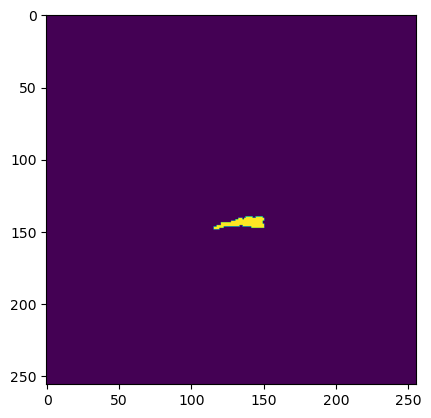

In [123]:
plt.imshow(train[13][1][0,:,:])

In [152]:
for step, (image, gt2D, boxes, sli) in enumerate(tqdm(train_loader)):

    if step != 13:
        continue
    #fac=0
    #boxes[0,0] += fac
    #boxes[0,2] += fac
    boxes=boxes*4
    print(boxes)
    image = image.to('cuda')
    gt2D = gt2D.to('cuda') # B x C x H x W
    boxes = boxes.to('cuda')
    #z = sam_model(image, boxes)
    #z = sam_model(image, multimask_output=False)

    z = medsam_model(image, boxes)
    '''
    z = torch.as_tensor(
            medsam_inference(medsam_model, image, boxes, 256, 256, as_one_hot=True,
            model_trained_on_multi_label=False, num_classes = 1)
        ).cuda()
    '''
    
    break

  0%|          | 13/48711 [00:01<1:31:59,  8.82it/s]

tensor([[464., 560., 600., 592.]])


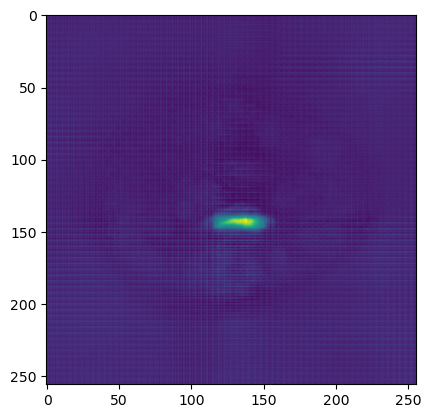

In [153]:
plt.imshow(z.detach().cpu().numpy()[0,0,:,:])
show_box(boxes.cpu().numpy().ravel(), plt.gca(), color = 'blue')